## Jupyter Notebook for the creation of mdtraj obtained data plots and PCA/tICA analysis


- First you need to import the important libraries. Maybe you need to add more libraries. Feel free to add them in this first cell
- Then you can load the functions that will be used later on. Nice_PES ia a function for plotting FEL plots in a nice way


In [1]:
# Useful stuff
import numpy as np
from itertools import combinations
import os
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter
import pandas as pd
import pytraj as pt
import glob

# PyEmma
import pyemma
import pyemma.msm as msm
import pyemma.plots as mpl
import pyemma.coordinates as coor

In [2]:
def plot_Nice_PES(P_test,bins=90,sigma=0.99, title=False, size = 1):

    mpl.style.use("seaborn-paper")
    plt.figure(figsize=(6*size,5*size))
    alldata=np.vstack(P_test)
    min1=np.min(alldata[:,0])
    max1=np.max(alldata[:,0])
    min2=np.min(alldata[:,1])
    max2=np.max(alldata[:,1])
    
    tickspacing1=1.0
    tickspacing2=1.0
    z,x,y = np.histogram2d(alldata[:,0], alldata[:,1], bins=bins)
    z += 0.1
    
    # compute free energies
    F = -np.log(z)
    
    
    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    
    plt.xticks(np.arange(int(min1), int(max1)+1, tickspacing1),fontsize=10*size)
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2),fontsize=10*size)
    #    sigma = 0.99 # this depends on how noisy your data is, play with it!
    data = gaussian_filter((F.T)*0.592-np.min(F.T)*0.592, sigma)
    levels=np.linspace(0,np.max(data)-0.5,num=10)
    plt.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
    plt.contourf(data,alpha=0.5,cmap='jet', cbar=True,levels=levels,extent=extent)
    if title:
        plt.title(title, fontsize = 20*size, y=1.02)
    plt.subplots_adjust(bottom=0.1, right=0.8, top=0.8)
    cax = plt.axes([0.81, 0.1, 0.02, 0.7])
    plt.colorbar(cax=cax, format='%.1f').set_label('Free energy (kcal/mol)', fontsize=10*size, labelpad=5, y= 0.5)
    cax.axes.tick_params(labelsize=10*size)

In [3]:
import matplotlib as mpl
#import nglview as nv
import ipywidgets as widgets
import pytraj as pt
import warnings
import tqdm
warnings.filterwarnings("ignore")
%pylab inline
%matplotlib inline

def interactive_FEL2(TICA_test, trajfiles, topfile, output_plot=True, n_frames=1,output_structure=False, size=1, bins=90, sigma=0.99, pc1=0, pc2=1):
    '''
        
        Plot the Free Energy Surface(FES) of the given data in a matplotlib pyqt. User can select a point in the FES. 
        
                
        If you experience some problem or you have any comment with this function --> https://github.com/miqueleg/compbiolab :3
        
        Parameters: ---------------------------------------------------------------------------------
        
        data: 3D ndarray (MD,frames,tic_dim). If not, the calculations will be wrong!!
        
        trajfiles: 1D array containing all trajectories strings containing files path and name(order in the list is important)
        
        topfile: string containing file path and name for the .pdb file that will be used as topology.
        
        output_plot: If true, a plot including the FES and selected pint will be displayed at the end.
            default=True
            
        output_structure: If True,the selected structure is also returned as pytraj structure.
            default=False
            
        size: Float/Integer that defines the size of the plots
            default=1
            
        
        Returns: -------------------------------------------------------------------------------------------
        
        - nglview of the structure selected
        
        - If output_structure=True, the selected structure is also returned as pytraj structure
        
        Only in in jupyter-notebook
          
    '''
    ##This imports are kind of necessary in order to plot the graphic in the Tk canvas(PQt5).
    ## At the end of the function, the matplotlib inline canvas has to be setted again in order to do not disturbe next plots
    %matplotlib qt

    ##Plot the Free energy surface as Nice_PES function
    mpl.style.use("seaborn-paper")
    fig, ax = plt.subplots(figsize=(6*size,5*size))
    alldata=np.vstack(TICA_test)
    min1=np.min(alldata[:,pc1])
    max1=np.max(alldata[:,pc1])
    min2=np.min(alldata[:,pc2])
    max2=np.max(alldata[:,pc2])
    print(all_data.shape)

    tickspacing1=1.0
    tickspacing2=1.0
    z,x,y = np.histogram2d(alldata[:,pc1], alldata[:,pc2], bins=bins)
    z += 0.1

    # compute free energies
    F = -np.log(z)

    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]

    plt.xticks(np.arange(int(min1), int(max1)+1, tickspacing1),fontsize=10*size)
    plt.yticks(np.arange(int(min2), int(max2)+1, tickspacing2),fontsize=10*size)
    #    sigma = 0.99 # this depends on how noisy your data is, play with it!
    data = gaussian_filter((F.T)*0.592-np.min(F.T)*0.592, sigma)
    levels=np.linspace(0,np.max(data)-0.5,num=8)
    ax.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
    ax.contourf(data,alpha=0.5,cmap='jet', cbar=True,levels=levels,extent=extent)

    ##ginput will wait until a click is done into the plot and collect the coordinates into the x variable
    x = plt.ginput()


    #nodes are the prepared data corresponding of the points on the TICA scatter (tic0 and tic1 by default)
    nodes = np.array(list(zip(alldata[:,pc1],alldata[:,pc2])))
    node = np.array(x[0])
    #cdist finction computes the distance matrix between TICA nodes and node
    distances = np.array(cdist([node], nodes))
    #clicked frame is the position in the matrix distance in wich you can find the minimun value
    clicked_frames = np.argsort(distances)[0]
    clicked_frames = clicked_frames[:n_frames]
    MD_out = pt.Trajectory(top=topfile)
    
    for f in tqdm.tqdm(range(len(clicked_frames))):
        clicked_frame = clicked_frames[f]
        MD=pt.iterload(trajfiles, top=topfile)
        MD_out.append(MD[clicked_frame])

        #Frames is a list containing the len of all the MD's.
        #This forces the input TICA_test to have a 3D shape (MD,frames,tic_dim). If not, the calculations are wrong!!
        Frames = []
        for traj in TICA_test:
            Frames.append(len(traj))
        #In this loop is computed in wich MD and MD_frame you can find the clicked frame
        MD = 0
        Frame = clicked_frame
        for i in list(range(len(Frames))):
            sum_frames = sum([Frames[j] for j in list(range(len(Frames))) if j <= i])
            if clicked_frame <= sum_frames:
                MD = i
                Frame = clicked_frame - sum([Frames[j] for j in list(range(len(Frames))) if j < i])
                break
            else:
                continue
    #The selected_frame is displayed using pytraj and nglview
    MD=pt.iterload(trajfiles, top=topfile)
    view=nv.show_pytraj(MD)
    view.clear()
    view.add_cartoon(selection="protein")
    view.frame = int(clicked_frame)

    #returning to the matplotlib inline
    %matplotlib inline
    #plot the selected position with a scatter
    if output_plot:
        plt.figure(figsize=(6*size,5*size))
        plt.contour(data,colors='black',linestyles='solid',alpha=0.7,cmap=None, cbar=True, levels=levels,extent=extent)
        plt.contourf(data,alpha=0.2,cmap='jet', cbar=True,levels=levels,extent=extent)
        plt.scatter(np.array(x)[:,0],np.array(x)[:,1], c ='b', s =50)
    if output_structure:
        return view, MD_out
    else:
        return view


Populating the interactive namespace from numpy and matplotlib


# 1 - Discretization

I start by defining the input files names and the input coordinates

In [4]:
directo='/home/janet/Desktop/DYN_HSVTK/TRAJS/THM/'
trajfiles_THM=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_THM='/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_THM.pdb'

directo='/home/janet/Desktop/DYN_HSVTK/TRAJS/THM_ATP/'
trajfiles_THM_ATP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_THM_ATP='/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_THM_ATP.pdb'

directo='/home/janet/Desktop/DYN_HSVTK/TRAJS/THM_ADP/'
trajfiles_THM_ADP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_THM_ADP='/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_THM_ADP.pdb'

directo='/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV/'
trajfiles_GCV=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_GCV='/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_GCV.pdb'

directo='/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV_ATP/'
trajfiles_GCV_ATP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_GCV_ATP='/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_GCV_ATP.pdb'

directo='/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV_ADP/'
trajfiles_GCV_ADP=[fi for fi in glob.glob(directo + '*_super.dcd')]
topfile_GCV_ADP='/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_GCV_ADP.pdb'

In [5]:
trajfiles_GCV_ATP


['/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV_ATP/dyn_MD_1E2K_GCV_ATP1_super.dcd',
 '/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV_ATP/dyn_MD_1E2K_GCV_ATP2_super.dcd',
 '/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV_ATP/dyn_MD_1E2K_GCV_ATP3_super.dcd']

In [6]:
trajfiles = []
trajfiles.append(trajfiles_THM)
trajfiles.append(trajfiles_THM_ATP)
trajfiles.append(trajfiles_THM_ADP)
trajfiles.append(trajfiles_GCV)
trajfiles.append(trajfiles_GCV_ATP)
trajfiles.append(trajfiles_GCV_ADP)
topfiles = []
topfiles.append(topfile_THM)
topfiles.append(topfile_THM_ATP)
topfiles.append(topfile_THM_ADP)
topfiles.append(topfile_GCV)
topfiles.append(topfile_GCV_ATP)
topfiles.append(topfile_GCV_ADP)

In [7]:
trajfiles

[['/home/janet/Desktop/DYN_HSVTK/TRAJS/THM/dyn_MD_1E2K_THM1_super.dcd',
  '/home/janet/Desktop/DYN_HSVTK/TRAJS/THM/dyn_MD_1E2K_THM2_super.dcd',
  '/home/janet/Desktop/DYN_HSVTK/TRAJS/THM/dyn_MD_1E2K_THM3_super.dcd'],
 ['/home/janet/Desktop/DYN_HSVTK/TRAJS/THM_ATP/dyn_MD_1E2K_THM_ATP1_super.dcd',
  '/home/janet/Desktop/DYN_HSVTK/TRAJS/THM_ATP/dyn_MD_1E2K_THM_ATP2_super.dcd',
  '/home/janet/Desktop/DYN_HSVTK/TRAJS/THM_ATP/dyn_MD_1E2K_THM_ATP3_super.dcd'],
 ['/home/janet/Desktop/DYN_HSVTK/TRAJS/THM_ADP/dyn_MD_1E2K_THMP_ADP_super.dcd',
  '/home/janet/Desktop/DYN_HSVTK/TRAJS/THM_ADP/dyn_MD_1E2K_THMP_ADP2_super.dcd',
  '/home/janet/Desktop/DYN_HSVTK/TRAJS/THM_ADP/dyn_MD_1E2K_THMP_ADP3_super.dcd'],
 ['/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV/dyn_MD_1E2K_GCV1_super.dcd',
  '/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV/dyn_MD_1E2K_GCV2_super.dcd',
  '/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV/dyn_MD_1E2K_GCV3_super.dcd'],
 ['/home/janet/Desktop/DYN_HSVTK/TRAJS/GCV_ATP/dyn_MD_1E2K_GCV_ATP1_super.dcd',
  

In [8]:
topfiles

['/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_THM.pdb',
 '/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_THM_ATP.pdb',
 '/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_THM_ADP.pdb',
 '/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_GCV.pdb',
 '/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_GCV_ATP.pdb',
 '/home/janet/Desktop/DYN_HSVTK/TOPS/MD_1E2K_GCV_ADP.pdb']

## analysis:

We normaly organize the data as the following: 
- FEATS are the lists variables that contains the data that will be used to extract info from the MD's (only based in the topfile). Feats list contain the feats for all systems. ej: feat1 == feats[0]
- SOURCES are the arrays containing the values of the feats for all frames

# PCA / TICA

In [10]:
feat1=pyemma.coordinates.featurizer(topfiles[0])
all_Ca1=feat1.select_Ca() # Features selected CA coordinates. The trajectories MUST be aligned first!
print(all_Ca1)            # if you want to avoid the aligning, you can use: feat1.add_distances_ca()
feat1.add_selection(all_Ca1)

feat2=pyemma.coordinates.featurizer(topfiles[1])
all_Ca2=feat2.select_Ca()
print(all_Ca2)
feat2.add_selection(all_Ca2)

feat3=pyemma.coordinates.featurizer(topfiles[2])
all_Ca3=feat3.select_Ca()
print(all_Ca3)
feat3.add_selection(all_Ca3)

feat4=pyemma.coordinates.featurizer(topfiles[3])
all_Ca4=feat4.select_Ca()
print(all_Ca4)
feat4.add_selection(all_Ca4)

feat5=pyemma.coordinates.featurizer(topfiles[4])
all_Ca5=feat5.select_Ca()
print(all_Ca5)
feat5.add_selection(all_Ca5)

feat6=pyemma.coordinates.featurizer(topfiles[5])
all_Ca6=feat6.select_Ca()
print(all_Ca6)
feat6.add_selection(all_Ca6)

[    4    29    35 ... 10008 10025 10032]
[    4    29    35 ... 10051 10068 10075]
[    4    29    35 ... 10050 10067 10074]
[    4    29    35 ... 10008 10025 10032]
[    4    29    35 ... 10051 10068 10075]
[    4    29    35 ... 10050 10067 10074]


In [11]:
 feat5

MDFeaturizer with features:
['ATOM:MET 1 CA 4 0 x',
 'ATOM:MET 1 CA 4 0 y',
 'ATOM:MET 1 CA 4 0 z',
 'ATOM:PRO 2 CA 29 0 x',
 'ATOM:PRO 2 CA 29 0 y',
 'ATOM:PRO 2 CA 29 0 z',
 'ATOM:THR 3 CA 35 0 x',
 'ATOM:THR 3 CA 35 0 y',
 'ATOM:THR 3 CA 35 0 z',
 'ATOM:LEU 4 CA 49 0 x', ...]

In [12]:
print(len(feat1.describe()))
print(len(feat2.describe()))
print(len(feat3.describe()))
print(len(feat4.describe()))
print(len(feat5.describe()))
print(len(feat6.describe()))

1974
1974
1974
1974
1974
1974


In [13]:
feats=[]
feats.append(feat1)
feats.append(feat2)
feats.append(feat3)
feats.append(feat4)
feats.append(feat5)
feats.append(feat6)

In [14]:
# This may take a while

sources=[]
print (len(feats[0].describe()))
for traj in range(0,len(topfiles)):
    print (traj,len(trajfiles))
    sources.append(pyemma.coordinates.load(trajfiles[traj],features=feats[traj]))

1974
0 6


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

1 6


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

2 6


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

3 6


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

4 6


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

5 6


Obtaining file info:   0%|          | 0/3 [00:00<?, ?it/s]

getting output of FeatureReader:   0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
np.array(sources).shape

(6, 3, 25000, 1974)

In [16]:
joint_data = sources[0] + sources[1] + sources[2] + sources [3] + sources [4] + sources [5]

## PCA

- Here the PCA space is created using all the data from all the systems. This can be done if we have the same features for all the different systems.
- Later on, the data is splitted for the different systems, but the space is the same

In [17]:
pca_joint=pyemma.coordinates.pca(data=joint_data,kinetic_map=False,stride=1)
pca_Y = pca_joint.get_output()
pca_THM, pca_THM_ATP, pca_THM_ADP, pca_GCV, pca_GCV_ATP, pca_GCV_ADP= np.split(pca_Y, np.cumsum(list(map(len, trajfiles)))[:-1])

calc mean+cov:   0%|          | 0/18 [00:00<?, ?it/s]

getting output of PCA:   0%|          | 0/18 [00:00<?, ?it/s]

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

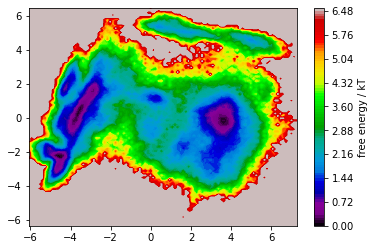

In [18]:
all_data=np.vstack(pca_Y)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

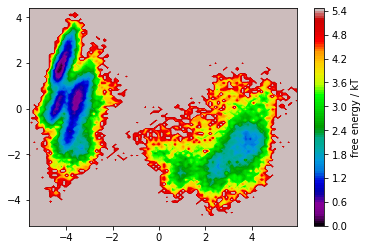

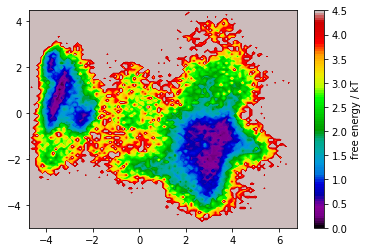

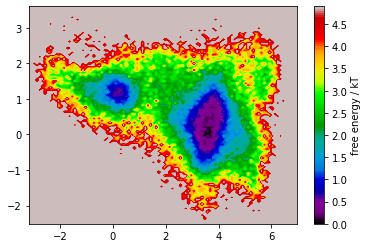

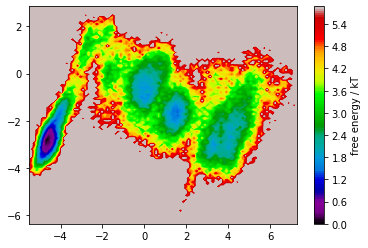

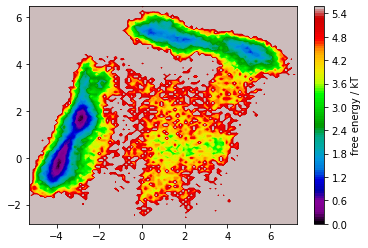

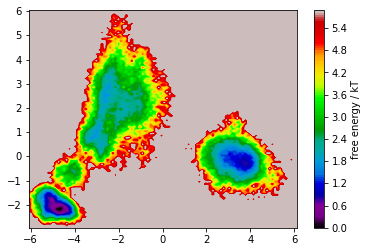

In [19]:
all_data=np.vstack(pca_THM)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

all_data=np.vstack(pca_THM_ATP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

all_data=np.vstack(pca_THM_ADP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

all_data=np.vstack(pca_GCV)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

all_data=np.vstack(pca_GCV_ATP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)

all_data=np.vstack(pca_GCV_ADP)
pyemma.plots.plot_free_energy(all_data[:,0], all_data[:,1], avoid_zero_count=1)


Here you will see the contributions of each feat (or the most important feats) for each PCA dimension (PC)

In [20]:
dist_PCA_correl = pca_joint.feature_PC_correlation

n_argmax = 2
for ii, icorr in enumerate(dist_PCA_correl.T):
    print("For PCA %u"%ii)
    argmaxs = [ii for ii in np.abs(icorr).argsort()[::-1] if not np.isnan(icorr[ii])]
    for art in argmaxs[:10]:
        print(str(art)+' %s %3.2f'%(feats[0].describe()[art], icorr[art]))
    print()

For PCA 0
1670 ATOM:GLU 559 CA 8482 3 z -0.93
1667 ATOM:ALA 558 CA 8472 3 z -0.92
1655 ATOM:PRO 554 CA 8428 3 z -0.92
1673 ATOM:PRO 560 CA 8505 3 z -0.92
1664 ATOM:GLY 557 CA 8465 3 z -0.91
1658 ATOM:PRO 555 CA 8442 3 z -0.91
1661 ATOM:GLN 556 CA 8448 3 z -0.91
1652 ATOM:VAL 553 CA 8404 3 z -0.89
1676 ATOM:GLN 561 CA 8511 3 z -0.88
1668 ATOM:GLU 559 CA 8482 3 x 0.87

For PCA 1
680 ATOM:ALA 227 CA 3433 0 z -0.72
681 ATOM:GLU 228 CA 3443 0 x -0.71
677 ATOM:GLY 226 CA 3426 0 z -0.70
684 ATOM:PRO 229 CA 3466 0 x -0.70
683 ATOM:GLU 228 CA 3443 0 z -0.67
687 ATOM:GLN 230 CA 3472 0 x -0.67
678 ATOM:ALA 227 CA 3433 0 x -0.66
675 ATOM:GLY 226 CA 3426 0 x -0.66
674 ATOM:GLN 225 CA 3409 0 z -0.65
686 ATOM:PRO 229 CA 3466 0 z -0.64

For PCA 2
676 ATOM:GLY 226 CA 3426 0 y -0.75
673 ATOM:GLN 225 CA 3409 0 y -0.74
679 ATOM:ALA 227 CA 3433 0 y -0.71
667 ATOM:PRO 223 CA 3389 0 y -0.69
670 ATOM:PRO 224 CA 3403 0 y -0.68
664 ATOM:VAL 222 CA 3365 0 y -0.68
533 ATOM:PRO 178 CA 2693 0 z 0.66
536 ATOM:GLY 17

In [21]:
import pickle

pickle.dump(pca_Y, open ("THM_VS_GCV_PCA/pca_Y.p", "wb"))
pickle.dump(pca_THM, open ("THM_VS_GCV_PCA/pca_THM.p", "wb"))
pickle.dump(pca_THM_ATP, open ("THM_VS_GCV_PCA/pca_THM_ATP.p", "wb"))
pickle.dump(pca_THM_ADP, open ("THM_VS_GCV_PCA/pca_THM_ADP.p", "wb"))
pickle.dump(pca_GCV, open ("THM_VS_GCV_PCA/pca_GCV.p", "wb"))
pickle.dump(pca_GCV_ATP, open ("THM_VS_GCV_PCA/pca_GCV_ATP.p", "wb"))
pickle.dump(pca_GCV_ADP, open ("THM_VS_GCV_PCA/pca_GCV_ADP.p", "wb"))

## tICA

The biggest difference between PCA and tICA is the introduction of the lag time parameter. With this parameter we can ignore fast movements that are not important for the system like vibrations and side chain rotations. Is important to chose a propper lag time that reduces the number of dimensions that explains the variations in the MD's.

To select a initial lag time, we use this code to sample different values and we select the one that explains the same variation in less dimensions (minimum in the plot)

###### This part may take a while

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

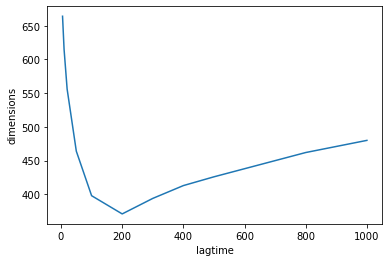

[5, [5, 664]]
[10, [10, 615]]
[20, [20, 556]]
[50, [50, 464]]
[100, [100, 398]]
[200, [200, 371]]
[300, [300, 394]]
[400, [400, 413]]
[500, [500, 426]]
[800, [800, 462]]
[1000, [1000, 480]]


In [22]:
#Compute TICA on the combined data from all trajectories

multi_tica=[]

for i in [5,10,20,50,100,200,300,400,500,800,1000]:
    tica_joint=pyemma.coordinates.tica(data=[t for t in joint_data if len(t)>1500],lag=i,stride=1)
    multi_tica.append([i,[tica_joint.lag, tica_joint.ndim]])
    del(tica_joint)
    
plt.plot([t[1][0] for t in multi_tica], [t[1][1]for t in multi_tica])
plt.xlabel('lagtime')
plt.ylabel('dimensions')
plt.show()
for tica in multi_tica:
    print(tica) 

## TICA

In [23]:
#%%time
lag=200   # We add the lag time that we selected in the previous part
tica_joint=pyemma.coordinates.tica(data=joint_data,lag=lag,kinetic_map=False,stride=1)
#kmeans=pyemma.coordinates.cluster_kmeans(data=None,k=25,max_iter=100)
#disc = pyemma.coordinates.discretizer(joint_data,transform=tica_joint,cluster=kmeans,stride=1)

#We get the output from tica on the combined dataset
Y_test = tica_joint.get_output()

#We know divide the tica output to recover the tica object for each dataset, i.e. tica for WT, tica for Lovd1..

tica_THM, tica_THM_ATP, tica_THM_ADP, tica_GCV, tica_GCV_ATP, tica_GCV_ADP = np.split(Y_test, np.cumsum(list(map(len, trajfiles)))[:-1])

calculate covariances:   0%|          | 0/18 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/18 [00:00<?, ?it/s]

In [24]:
tica_THM.shape

(3, 25000, 371)

(<Figure size 432x288 with 2 Axes>, <AxesSubplot:>)

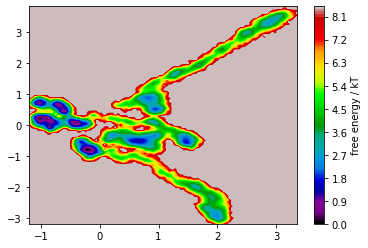

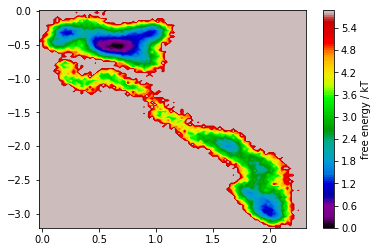

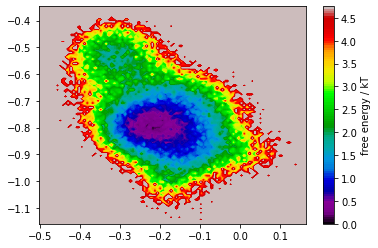

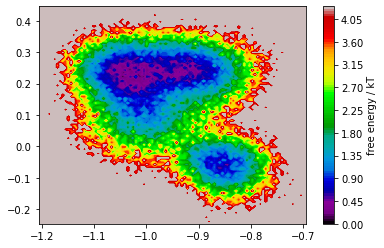

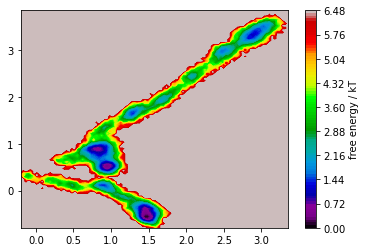

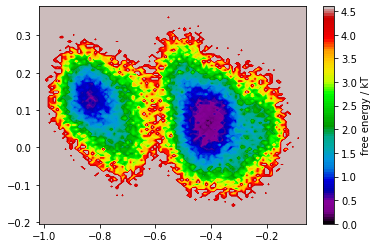

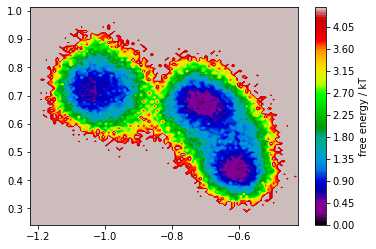

In [25]:
#We now compute the free energy of the combined dataset and separated datasets

dims = 0,1

all_data=np.vstack(Y_test)
pyemma.plots.plot_free_energy(all_data[:,dims[0]], all_data[:,dims[1]], avoid_zero_count=1)

all_data_3=np.vstack(tica_THM)
pyemma.plots.plot_free_energy(all_data_3[:,dims[0]], all_data_3[:,dims[1]], avoid_zero_count=1)

all_data_4=np.vstack(tica_THM_ATP)
pyemma.plots.plot_free_energy(all_data_4[:,dims[0]], all_data_4[:,dims[1]], avoid_zero_count=1)

all_data_5=np.vstack(tica_THM_ADP)
pyemma.plots.plot_free_energy(all_data_5[:,dims[0]], all_data_5[:,dims[1]], avoid_zero_count=1)

all_data_6=np.vstack(tica_GCV)
pyemma.plots.plot_free_energy(all_data_6[:,dims[0]], all_data_6[:,dims[1]], avoid_zero_count=1)

all_data_7=np.vstack(tica_GCV_ATP)
pyemma.plots.plot_free_energy(all_data_7[:,dims[0]], all_data_7[:,dims[1]], avoid_zero_count=1)

all_data_8=np.vstack(tica_GCV_ADP)
pyemma.plots.plot_free_energy(all_data_8[:,dims[0]], all_data_8[:,dims[1]], avoid_zero_count=1)

In [26]:
dist_TIC_correl = tica_joint.feature_TIC_correlation

n_argmax = 2
for ii, icorr in enumerate(dist_TIC_correl.T):
    print("For TIC %u"%ii)
    argmaxs = [ii for ii in np.abs(icorr).argsort()[::-1] if not np.isnan(icorr[ii])]
    for art in argmaxs[:20]:
        print(str(art)+' %s %3.2f'%(feats[0].describe()[art], icorr[art]))
    print()

For TIC 0
533 ATOM:PRO 178 CA 2693 0 z 0.75
528 ATOM:ARG 177 CA 2661 0 x 0.73
48 ATOM:LYS 17 CA 248 0 x 0.71
530 ATOM:ARG 177 CA 2661 0 z 0.71
512 ATOM:ARG 171 CA 2545 0 z 0.70
531 ATOM:PRO 178 CA 2693 0 x 0.69
537 ATOM:GLU 180 CA 2706 0 x 0.68
521 ATOM:LYS 174 CA 2598 0 z 0.68
536 ATOM:GLY 179 CA 2699 0 z 0.68
1038 ATOM:THR 349 CA 5309 3 x -0.68
509 ATOM:ASP 170 CA 2533 0 z 0.67
527 ATOM:GLN 176 CA 2644 0 z 0.67
1520 ATOM:PRO 509 CA 7732 3 z -0.66
846 ATOM:ASP 283 CA 4320 0 x 0.66
534 ATOM:GLY 179 CA 2699 0 x 0.66
854 ATOM:ASP 285 CA 4353 0 z -0.66
852 ATOM:ASP 285 CA 4353 0 x 0.66
1523 ATOM:GLY 510 CA 7738 3 z -0.65
524 ATOM:ARG 175 CA 2620 0 z 0.65
1335 ATOM:ASP 448 CA 6761 3 x -0.64

For TIC 1
1034 ATOM:GLY 347 CA 5280 3 z 0.80
1037 ATOM:LYS 348 CA 5287 3 z 0.75
1031 ATOM:MET 346 CA 5263 3 z 0.71
1040 ATOM:THR 349 CA 5309 3 z 0.69
1046 ATOM:THR 351 CA 5337 3 z 0.60
153 ATOM:ILE 52 CA 799 0 x -0.59
150 ATOM:THR 51 CA 785 0 x -0.58
1043 ATOM:THR 350 CA 5323 3 z 0.56
1028 ATOM:GLY 345

In [27]:
pickle.dump(Y_test, open ("THM_VS_GCV_PCA/tica_Y.p", "wb"))
pickle.dump(tica_THM, open ("THM_VS_GCV_PCA/tica_THM.p", "wb"))
pickle.dump(tica_THM_ATP, open ("THM_VS_GCV_PCA/tica_THM_ATP.p", "wb"))
pickle.dump(tica_THM_ADP, open ("THM_VS_GCV_PCA/tica_THM_ADP.p", "wb"))
pickle.dump(tica_GCV, open ("THM_VS_GCV_PCA/tica_GCV.p", "wb"))
pickle.dump(tica_GCV_ATP, open ("THM_VS_GCV_PCA/tica_GCV_ATP.p", "wb"))
pickle.dump(tica_GCV_ADP, open ("THM_VS_GCV_PCA/tica_GCV_ADP.p", "wb"))

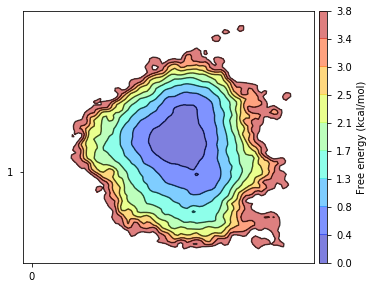

In [51]:
plot_Nice_PES (tica_GCV, bins=95)

(375000, 487)


100%|██████████| 1/1 [00:00<00:00, 41.33it/s]


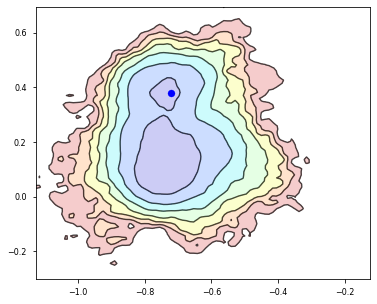

In [152]:
i = 4
view, frame = interactive_FEL2(tica_GCV, trajfiles=trajfiles[i], topfile=topfiles[i], pc1=0, pc2=1,output_structure=True)

In [153]:
selected = pt.Trajectory(top=topfiles[i])
selected.append(frame)
selected.save('../withAPO/U_GCV.pdb', overwrite=True)

### MDTRAJ RMSF

In [28]:
topfiles

['/home/miquel/Desktop/Janet/OLD_PDB/MD_1E2K_APO.pdb',
 '/home/miquel/Desktop/Janet/OLD_PDB/MD_1E2K_ADP.pdb',
 '/home/miquel/Desktop/Janet/OLD_PDB/MD_1E2K_ATP.pdb',
 '/home/miquel/Desktop/Janet/OLD_PDB/MD_1E2K_THM.pdb',
 '/home/miquel/Desktop/Janet/OLD_PDB/MD_1E2K_GCV.pdb']

In [32]:
del APO, ADP, ATP, THM_ATP,GCV_ATP

In [ ]:
# Load pytraj trajectories

APO = pt.iterload(trajfiles[0], top=topfiles[0])
ADP = pt.iterload(trajfiles[1], top=topfiles[1])
ATP = pt.iterload(trajfiles[2], top=topfiles[2])
THM_ATP = pt.iterload(trajfiles[3], top=topfiles[3])
GCV_ATP = pt.iterload(trajfiles[4], top=topfiles[4])

# Compute RMSF
APO_rmsf = pt.atomicfluct(APO,'@CA')
ADP_rmsf = pt.atomicfluct(ADP,'@CA')
ATP_rmsf = pt.atomicfluct(ATP,'@CA')
THM_ATP_rmsf = pt.atomicfluct(THM_ATP,'@CA')
GCV_ATP_rmsf = pt.atomicfluct(GCV_ATP,'@CA')


In [ ]:
# Plot

fig, [ax1,ax2,ax3,ax4,ax5] = plt.subplots(5,1,figsize=(15,10), sharey=True)
ax1.plot(APO_rmsf[:,1])
ax2.plot(ADP_rmsf[:,1])
ax3.plot(ATP_rmsf[:,1])
ax4.plot(THM_ATP_rmsf[:,1])
ax5.plot(GCV_ATP_rmsf[:,1])
ax2.set_xlim(0,665)
ax3.set_xlim(0,665)
ax4.set_xlim(0,665)
ax4.set_xlim(0,665)
ax1.set_title('APO', fontsize=20)
ax2.set_title('ADP', fontsize=20)
ax3.set_title('ATP', fontsize=20)
ax4.set_title('THM_ATP', fontsize=20)
ax5.set_title('GCV_ATP', fontsize=20)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()

In [ ]:
fig = plt.figure(figsize=(20,5))
#residues = [177]
#xs = [1,50,100,150,200,274,324,374,434,498,548,598,648,750]
x = list(range(len(APO_rmsf)))
plt.plot(x,APO_rmsf[:,1], label='APO')
plt.plot(x,ADP_rmsf[:,1], label='ADP')
plt.plot(x,ATP_rmsf[:,1], label='ATP')
plt.plot(x,THM_rmsf[:,1], label='THM_ATP')
plt.plot(x,GCV_rmsf[:,1], label='GCV_ATP')
plt.grid()
plt.legend(fontsize=20)
plt.title(' @Cα RMSF Analysis of HSV-TK ', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Residue Number',fontsize=25)
plt.ylabel('RMSF($\AA$)',fontsize=25)
plt.yticks(fontsize=15)
plt.xlim(-4,780)
#plt.xticks(xs, residues, rotation='vertical')
print('')

In [179]:
del APO,ADP,ATP,THM,GCV

### MDtraj distances plots